# exploring different areas of text analytics.
_Looking to learn more about text analytics. My overall goal is to train an accurate sentiment analyzer_

*Amazon Customer Reviews with Sentiment
- https://www.kaggle.com/datasets/thedevastator/amazon-customer-reviews-with-2013-2019-sentiment

## methods I'm exploring 

### * Bag of Words method
> - taking each word from a sentence to get some kind of measure by which we can find out if the word exists in another sentence or not and also its importance
> - each sentence in the google reviews will be treated as a bag of words, in other words each sentence is a **document** and all the documents make up a **corpus**

#### goals
1. create a dictionary of all the unique words in the corpus (exclusding words like "the", "an", "is" etc)
1. convert all documents into vectors which will represent the presence of words from our dictionary in the documents.
* *We're going to do this with the Tf-idf vectorizer in sklearn*

#### steps
1. Count the number of times each word appears in each document(hotel review)
    1. create feature vector and find out of how many zeroes are in my feature vector.
    1. calculate the non-zero value density in the vector
    1. remove stopwords and non-english characters
    1. test stemming or lemmatization

In [1]:
# import dependencies
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import regex as re
import warnings
warnings.filterwarnings('ignore')

# load data

In [2]:
initData = pd.read_csv('resources/Amazon Review Data Web Scrapping - Amazon Review Data Web Scrapping.csv', encoding='ISO-8859-1')

## let's do some quick initial cleaning and exploring into the dataset

In [3]:
initData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60889 entries, 0 to 60888
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unique_ID      60889 non-null  int64 
 1   Category       60889 non-null  object
 2   Review_Header  60884 non-null  object
 3   Review_text    60857 non-null  object
 4   Rating         60889 non-null  int64 
 5   Own_Rating     60889 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


In [4]:
# we can get a quick overview of how many reviews share the same text with value_counts function
initData['Review_text'].value_counts()

Review_text
Good                                                                                                                                                                                                                            2316
Nice                                                                                                                                                                                                                             707
Good product                                                                                                                                                                                                                     487
Ok                                                                                                                                                                                                                               297
Excellent                                                               

In [5]:
# how many nans are in the dataset
initData['Review_text'].isna().sum()

32

In [6]:
# drop the nans 
initData = initData.dropna()

In [7]:
# show count of nans again to make sure its 0
initData['Review_text'].isna().sum()

0

In [8]:
# show overall counts of reviews by sentiment
initData['Own_Rating'].value_counts()

Own_Rating
Positive    47406
Negative     9086
Neutral      4363
Name: count, dtype: int64

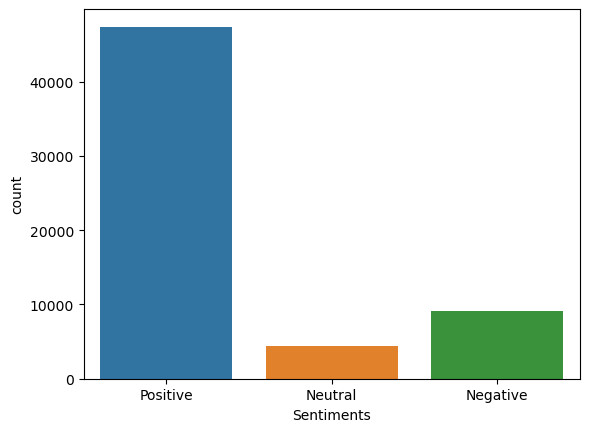

In [9]:
# visualize sentimemt distribution 
sns.countplot(x = 'Own_Rating', data = initData)
plt.xlabel('Sentiments')

plt.show()

## * Bag of Words method start

In [10]:
# create the countvectorizer 
count_vector = CountVectorizer()

In [11]:
# create dictionary of words from the corpus
features = count_vector.fit(initData['Review_text'])

In [12]:
# I want to check out some words that got extracted from the corpus
feature_names = features.get_feature_names_out()
feature_names

array(['00', '000', '0008301163', ..., 'ã²sm', 'ð²î', 'ð²ñ'], dtype=object)

In [13]:
print(f'Total number of features extracted are: {len(feature_names)}')

Total number of features extracted are: 27301


**ok bet, we have 27301 unique features identified**

In [14]:
# creating a random sampler to show 10 feature names
random.sample(sorted(feature_names),10)

['balloon',
 'togeather',
 'classy',
 'guies',
 'highlighter',
 'foodie',
 'rashmi',
 '600rs',
 'amout',
 'prompted']

In [15]:
# creating feature vector
feature_vector = count_vector.transform(initData['Review_text'])
feature_vector.shape

(60855, 27301)

#### the above shows us all 60,855 documents, are represented by 27,301 features(unique words)
> corresponding features will carry the number of times that word appeard in the document. If the word is not present then the feature gets a 0 value

In [16]:
# I need to find out of how many zeroes are in my feature vector
feature_vector.getnnz()

1150642

In [17]:
# gets the non-zero value density in the document
feature_vector.getnnz()/(feature_vector.shape[0]*feature_vector.shape[1])

0.0006925727512887749

wayyy too many zeroes in my feature vector **sadnesss -_-**

In [18]:
# show sparse matrix
feature_vector.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

#### need to fix the dataset before moving forward

#### * getting rid of stopwords

In [19]:
# create stopwords variable set to english
all_stopwords = set(stopwords.words('english'))

#### do feature vector process again, using all_stopwords variable to remove the stopwords

In [20]:
count_vector2 = CountVectorizer(stop_words=list(all_stopwords))

In [21]:
feature_names2 = count_vector2.fit(initData['Review_text'])

In [22]:
feature_vector2 = count_vector2.transform(initData['Review_text'])
feature_vector2.shape

(60855, 27159)

#### the above shows us all 60,855 documents, are now represented by 27,159 features. **142 less with stop words removed
> need to reduce more!

In [23]:
# make a df showing feature counts 
feature_names = feature_names2.get_feature_names_out()
feature_counts = np.sum(feature_vector2.toarray(),axis = 0)
featureCountDf = pd.DataFrame(dict(Features = feature_names, Count = feature_counts))

In [24]:
featureCountDf

,Features,Count
0,00,35
1,000,137
2,0008301163,1
3,0009001009009,2
4,000above,1
...,...,...
27154,áº,1
27155,â½,5
27156,ã²sm,1
27157,ð²î,1


In [25]:
reviewsCopy = initData.copy()

In [26]:
# use regex to go through each document and look for mumbers and non-englisgh characters then replace them with a space
sentences =[]
for word in reviewsCopy.Review_text:
    review = re.sub('[^a-zA-Z]',' ',word)
    review = review.lower()
    sentences.append(review)

#### let's see the count difference in the feature vector now using sentences list

In [27]:
count_vector3 = CountVectorizer(stop_words=list(all_stopwords))

In [28]:
feature_names3 = count_vector3.fit(sentences)

In [29]:
feature_vector3= count_vector3.transform(sentences)
feature_vector3.shape

(60855, 23477)

#### the above shows us all 60,855 documents, are now represented by 23,477 features. **3,824 less with stop words and non-english characters removed

In [30]:
# make a df showing feature counts 
feature_names = feature_names3.get_feature_names_out()
feature_counts = np.sum(feature_vector3.toarray(),axis = 0)
featureCountDf = pd.DataFrame(dict(Features = feature_names, Count = feature_counts))

In [31]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
featureCountDf

,Features,Count
0,aa,22
1,aaa,14
2,aaaamazing,1
3,aab,1
4,aacha,3
...,...,...
23472,zyaada,1
23473,zyada,4
23474,zyda,1
23475,zyming,1


#### next step is to stem our documents

In [32]:
# create porterstemmer 
ps = PorterStemmer()

In [33]:
# stem individual words and remove stopwords
sentences_stemmed = []
for texts in sentences:
    reviews = [ps.stem(word) for word in texts.split() if not word in all_stopwords]
    sentences_stemmed.append(' '.join(reviews))

#### let's get our new count

In [34]:
count_vector4 = CountVectorizer()

In [35]:
feature_names4 = count_vector4.fit(sentences_stemmed)

In [36]:
feature_vector4= count_vector4.transform(sentences_stemmed)
feature_vector4.shape

(60855, 16945)

#### the above shows us all 60,855 documents, are now represented by 16,945 features. **10,356 less with stop words removed

#### next steps are to lemmatize

In [37]:
# create lemmatizer object
lemma = WordNetLemmatizer()

In [38]:
# lemmatize and remove stopwords
sentences_lemma = []
for texts in sentences:
    reviews = [lemma.lemmatize(word) for word in texts.split() if not word in all_stopwords]
    sentences_lemma.append(' '.join(reviews))

#### time to create my vector again and see how I'm looking

In [39]:
count_vector5 = CountVectorizer()

In [40]:
feature_names5 = count_vector5.fit(sentences_lemma)

In [41]:
feature_vector5= count_vector5.transform(sentences_lemma)
feature_vector5.shape

(60855, 21612)

#### the above shows us all 60,855 documents, are now represented by 21,612 features. **5,689 less with stop words removed and lemmatized.
#### i'll be moving forward with porter stemmer

In [42]:
# creating function to do the cleaning process discovered here, and apply it to main dataframe
def get_clean_text(df,col):
    sentence = []
    
    for word in df[col][:]:
        review = re.sub('[^a-zA-Z]',' ',word)
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if not word in all_stopwords]
        review = ' '.join(review)
        sentence.append(review)
        
    return sentence

In [43]:
reviewsCopy['clean_text'] = get_clean_text(reviewsCopy,'Review_text' )

## classification part

In [44]:
# get rid of neutral reviews
reviewsCopy2 = reviewsCopy[reviewsCopy['Own_Rating']!='Neutral']

In [45]:
# Replace all instances of the value 'positive' with the value 1
reviewsCopy2 = reviewsCopy2.replace('Positive', 1)
reviewsCopy2 = reviewsCopy2.replace('Negative', 0)

In [46]:
reviewsCopy2.head()

,Unique_ID,Category,Review_Header,Review_text,Rating,Own_Rating,clean_text
0,136040,smartTv,Nice one,I liked it,5,1,like
1,134236,mobile,Huge battery life with amazing display,I bought the phone on Amazon and been using my...,5,1,bought phone amazon use samsung coupl week del...
2,113945,books,Four Stars,"Awesome book at reasonable price, must buy ......",4,1,awesom book reason price must buy
3,168076,smartTv,Nice quality,good,5,1,good
5,146539,smartTv,Nice tv,Nice tv and pic quality .good custmer srrvice ...,5,1,nice tv pic qualiti good custmer srrvice tv in...


In [47]:
# time to vectorize again! 
cv = CountVectorizer()
features = cv.fit_transform(reviewsCopy2['clean_text'])

In [48]:
#splitting the dataset into train and test
x = features.toarray()
y = reviewsCopy2['Own_Rating']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, random_state = 42)

In [49]:
# build and train the GaussianNB model
classifier = GaussianNB()
classifier.fit(x_train, y_train)

GaussianNB()

In [50]:
# test the model
y_pred = classifier.predict(x_test)

In [51]:
# let's see those results
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[ 814  110]
 [4019  707]]


In [52]:
round(accuracy_score(y_test, y_pred), 3)

0.269

#### there are 4019 false negatives -_- and i have a 26% accuracy score. Horrible 

In [ ]:
y_pred_train = classifier.predict(x_train)

In [ ]:
round(accuracy_score(y_train, y_pred_train), 3)